In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.graphics.tsaplots import plot_pacf
from lifelines import KaplanMeierFitter

In [10]:
ati_df = pd.read_csv('allocated_time_interval_to_event_spans.csv')
ati_df = ati_df[['ATI_ALLOCATED_TIME_INTERVAL_ID','ATI_SHIFT_ENTRY_ID','ATI_ARRAY_FAMILY','ATI_TIME_SPAN','ATI_START_TIME','ATI_END_TIME','EVENTS_EB_UID',
                 'EVENT_CODE','EVENTS_EXECUTION_STATUS','EVENTS_TIME_SPAN','EVENTS_START_TIME','EVENTS_END_TIME','DT_SUBJECT','DT_DOWNTIME_TYPE','DT_START_TIME','DT_END_TIME','DT_TIME_SPAN']]

#generate time data
ati_df['ATI_START_TIME'] = pd.to_datetime(ati_df.ATI_START_TIME)
ati_df['ATI_END_TIME'] = pd.to_datetime(ati_df.ATI_END_TIME)
ati_df['EVENTS_START_TIME'] = pd.to_datetime(ati_df.EVENTS_START_TIME)
ati_df['EVENTS_END_TIME'] = pd.to_datetime(ati_df.EVENTS_END_TIME)
ati_df['DT_START_TIME'] = pd.to_datetime(ati_df.DT_START_TIME)
ati_df['DT_END_TIME'] = pd.to_datetime(ati_df.DT_END_TIME)

#Downtime classification
ati_df['DT_CLASS'] = ati_df['DT_TIME_SPAN']

ati_df['hour'] = [x.hour for x in ati_df.ATI_START_TIME]
ati_df['day'] = [x.day for x in ati_df.ATI_START_TIME]
ati_df['month'] = [x.month for x in ati_df.ATI_START_TIME]
ati_df['year'] = [x.year for x in ati_df.ATI_START_TIME]
ati_df['year-month'] = [str(x.year) + "-" + str(x.month) for x in ati_df.ATI_START_TIME]


#Chilean seasons:  Summer (December to February), Autumn (March to May), Winter (June to August) and Spring (September to November).
season_map = {1:'summer', 
               2:'summer', 
               3:'autumn', 
               4:'autumn',
               5:'autumn',
               6:'winter',
               7:'winter',
               8:'winter',
               9:'spring',
               10:'spring',
               11:'spring',
               12:'summer'}
ati_df['season'] = ati_df['month'].map(season_map)


ati_df=ati_df.drop_duplicates()
pd.set_option('display.max_columns', None)

ati_df.dtypes

ATI_ALLOCATED_TIME_INTERVAL_ID                  int64
ATI_SHIFT_ENTRY_ID                              int64
ATI_ARRAY_FAMILY                               object
ATI_TIME_SPAN                                 float64
ATI_START_TIME                    datetime64[ns, UTC]
ATI_END_TIME                      datetime64[ns, UTC]
EVENTS_EB_UID                                  object
EVENT_CODE                                     object
EVENTS_EXECUTION_STATUS                        object
EVENTS_TIME_SPAN                                int64
EVENTS_START_TIME                 datetime64[ns, UTC]
EVENTS_END_TIME                   datetime64[ns, UTC]
DT_SUBJECT                                     object
DT_DOWNTIME_TYPE                               object
DT_START_TIME                     datetime64[ns, UTC]
DT_END_TIME                       datetime64[ns, UTC]
DT_TIME_SPAN                                    int64
DT_CLASS                                        int64
hour                        

In [11]:
ati_df=ati_df.drop_duplicates()
ati_df

,ATI_ALLOCATED_TIME_INTERVAL_ID,ATI_SHIFT_ENTRY_ID,ATI_ARRAY_FAMILY,ATI_TIME_SPAN,ATI_START_TIME,ATI_END_TIME,EVENTS_EB_UID,EVENT_CODE,EVENTS_EXECUTION_STATUS,EVENTS_TIME_SPAN,EVENTS_START_TIME,EVENTS_END_TIME,DT_SUBJECT,DT_DOWNTIME_TYPE,DT_START_TIME,DT_END_TIME,DT_TIME_SPAN,DT_CLASS,hour,day,month,year,year-month,season
0,1864,779489,Total Power,1.0,2015-05-16 03:19:00+00:00,2015-05-16 03:20:00+00:00,NaN,NaN,NaN,0,NaT,NaT,NaN,NaN,NaT,NaT,0,0,3,16,5,2015,2015-5,autumn
1,1381,779076,7 [m],895.0,2015-05-14 20:59:10.301000+00:00,2015-05-15 11:54:17.467000+00:00,uid://A002/Xa08aa0/X4b8,SBEX,SUCCESS,74,2015-05-14 22:03:16.575000+00:00,2015-05-14 23:18:02.180000+00:00,NaN,NaN,NaT,NaT,0,0,20,14,5,2015,2015-5,autumn
2,1381,779076,7 [m],895.0,2015-05-14 20:59:10.301000+00:00,2015-05-15 11:54:17.467000+00:00,uid://A002/Xa08aa0/X304,SBEX,SUCCESS,29,2015-05-14 21:19:34.499000+00:00,2015-05-14 21:48:49.738000+00:00,NaN,NaN,NaT,NaT,0,0,20,14,5,2015,2015-5,autumn
3,1381,779076,7 [m],895.0,2015-05-14 20:59:10.301000+00:00,2015-05-15 11:54:17.467000+00:00,uid://A002/Xa08aa0/Xf3a,SBEX,SUCCESS,22,2015-05-15 00:58:43.787000+00:00,2015-05-15 01:21:23.057000+00:00,NaN,NaN,NaT,NaT,0,0,20,14,5,2015,2015-5,autumn
4,1381,779076,7 [m],895.0,2015-05-14 20:59:10.301000+00:00,2015-05-15 11:54:17.467000+00:00,uid://A002/Xa08aa0/X1146,SBEX,FAIL,5,2015-05-15 01:21:59.483000+00:00,2015-05-15 01:27:36.848000+00:00,NaN,NaN,NaT,NaT,0,0,20,14,5,2015,2015-5,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148115,53833,1925292,Total Power,3115.0,2023-01-30 12:00:47.247000+00:00,2023-02-01 15:56:31.375000+00:00,uid://A002/X102e90f/Xad2,SBEX,SUCCESS,85,2023-01-30 14:49:04.840000+00:00,2023-01-30 16:14:41.556000+00:00,NaN,NaN,NaT,NaT,0,0,12,30,1,2023,2023-1,summer
148116,53833,1925292,Total Power,3115.0,2023-01-30 12:00:47.247000+00:00,2023-02-01 15:56:31.375000+00:00,uid://A002/X102e90f/X1266,SBEX,FAIL,2,2023-01-30 16:16:31.688000+00:00,2023-01-30 16:19:06.399000+00:00,NaN,NaN,NaT,NaT,0,0,12,30,1,2023,2023-1,summer
148117,53833,1925292,Total Power,3115.0,2023-01-30 12:00:47.247000+00:00,2023-02-01 15:56:31.375000+00:00,uid://A002/X102e90f/X1653,SBEX,SUCCESS,85,2023-01-30 16:58:15.935000+00:00,2023-01-30 18:23:23.507000+00:00,NaN,NaN,NaT,NaT,0,0,12,30,1,2023,2023-1,summer
148119,53833,1925292,Total Power,3115.0,2023-01-30 12:00:47.247000+00:00,2023-02-01 15:56:31.375000+00:00,uid://A002/X102ed74/X32b5,SBEX,SUCCESS,59,2023-01-31 02:58:05.156000+00:00,2023-01-31 03:57:12.430000+00:00,NaN,NaN,NaT,NaT,0,0,12,30,1,2023,2023-1,summer


## Classify > 10 min, < 10 min., semi-shutdown (certain array families), all operations shutdown

In [12]:
ati_agg = pd.DataFrame(ati_df.groupby([ati_df.ATI_START_TIME.dt.date,'hour','month','year','ATI_SHIFT_ENTRY_ID','ATI_ALLOCATED_TIME_INTERVAL_ID','EVENTS_EB_UID','ATI_ARRAY_FAMILY','EVENT_CODE','EVENTS_EXECUTION_STATUS']).agg({'ATI_TIME_SPAN':'median',
                                                                                                                                                                                                           'EVENTS_TIME_SPAN':'sum',
                                                                                                                                                                                                           'DT_TIME_SPAN':'sum'})).reset_index()
ati_agg

,ATI_START_TIME,hour,month,year,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,EVENTS_EB_UID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN
0,2015-03-31,20,3,2015,761400,61,uid://A002/X9cffbd/X114e,12 [m],MMEX,SUCCESS,767.0,5,0
1,2015-03-31,20,3,2015,761400,61,uid://A002/X9cffbd/X116d,12 [m],MMEX,SUCCESS,767.0,5,0
2,2015-03-31,20,3,2015,761400,61,uid://A002/X9cffbd/X27c,12 [m],SBEX,FAIL,767.0,11,0
3,2015-03-31,20,3,2015,761400,61,uid://A002/X9cffbd/X30a,12 [m],SBEX,SUCCESS,767.0,35,0
4,2015-03-31,20,3,2015,761400,61,uid://A002/X9cffbd/X3d,12 [m],MMEX,SUCCESS,767.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127005,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X48c2,Total Power,SBEX,SUCCESS,3115.0,74,0
127006,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X5126,Total Power,SBEX,SUCCESS,3115.0,74,0
127007,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X9e1,Total Power,SBEX,SUCCESS,3115.0,59,0
127008,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/Xc,Total Power,SBEX,SUCCESS,3115.0,5,0


### Need to create new table to aggregate daily allocated time by family and later join

In [15]:
#ATI SPAN CALC
ati_daily_calc = pd.DataFrame(ati_agg.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'ATI_TIME_SPAN':'median'})).rename({'ATI_TIME_SPAN':'ATI_TIME_TOTAL'}, axis=1).reset_index()
ati_daily_calc.tail(7)

,ATI_START_TIME,ATI_ARRAY_FAMILY,ATI_TIME_TOTAL
4778,2023-01-28,Total Power,1438.0
4779,2023-01-29,12 [m],1440.0
4780,2023-01-29,7 [m],1440.0
4781,2023-01-29,Total Power,1440.0
4782,2023-01-30,12 [m],3115.0
4783,2023-01-30,7 [m],3115.0
4784,2023-01-30,Total Power,3115.0


In [16]:
event_daily_calc = pd.DataFrame(ati_agg.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'EVENTS_TIME_SPAN':'sum'})).rename({'EVENTS_TIME_SPAN':'EVENTS_TIME_TOTAL'}, axis=1).reset_index()
event_daily_calc.tail(7)

,ATI_START_TIME,ATI_ARRAY_FAMILY,EVENTS_TIME_TOTAL
4778,2023-01-28,Total Power,664
4779,2023-01-29,12 [m],934
4780,2023-01-29,7 [m],941
4781,2023-01-29,Total Power,929
4782,2023-01-30,12 [m],718
4783,2023-01-30,7 [m],1012
4784,2023-01-30,Total Power,1033


In [17]:
dt_daily_calc = pd.DataFrame(ati_agg.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'DT_TIME_SPAN':'sum'})).rename({'DT_TIME_SPAN':'DT_TIME_TOTAL'}, axis=1).reset_index()
dt_daily_calc.tail(7)

,ATI_START_TIME,ATI_ARRAY_FAMILY,DT_TIME_TOTAL
4778,2023-01-28,Total Power,0
4779,2023-01-29,12 [m],396
4780,2023-01-29,7 [m],412
4781,2023-01-29,Total Power,0
4782,2023-01-30,12 [m],0
4783,2023-01-30,7 [m],0
4784,2023-01-30,Total Power,0


In [18]:
#merge
ati_agg_merge = pd.merge(ati_agg, ati_daily_calc, on=['ATI_START_TIME','ATI_ARRAY_FAMILY'], how='left')
ati_agg_merge = pd.merge(ati_agg_merge, event_daily_calc, on=['ATI_START_TIME','ATI_ARRAY_FAMILY'], how='left')
ati_agg_merge = pd.merge(ati_agg_merge, dt_daily_calc, on=['ATI_START_TIME','ATI_ARRAY_FAMILY'], how='left')




#ati_agg_test['EVENT_SPAN_SUM'] = ati_agg_test.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY'])['EVENTS_TIME_SPAN'].transform(np.sum)
#ati_agg_test['DT_SPAN_SUM'] = ati_agg_test.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY'])['DT_TIME_SPAN'].transform(np.sum)
ati_agg_merge['pct_utilization'] = (ati_agg_merge['EVENTS_TIME_TOTAL']) / ati_agg_merge['ATI_TIME_TOTAL']
ati_agg_merge.tail(10)

,ATI_START_TIME,hour,month,year,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,EVENTS_EB_UID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN,ATI_TIME_TOTAL,EVENTS_TIME_TOTAL,DT_TIME_TOTAL,pct_utilization
127000,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X26a,Total Power,SBEX,SUCCESS,3115.0,59,0,3115.0,1033,0,0.331621
127001,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X28b1,Total Power,SBEX,SUCCESS,3115.0,60,0,3115.0,1033,0,0.331621
127002,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X32b5,Total Power,SBEX,SUCCESS,3115.0,59,0,3115.0,1033,0,0.331621
127003,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X3a02,Total Power,SBEX,SUCCESS,3115.0,58,0,3115.0,1033,0,0.331621
127004,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X402e,Total Power,SBEX,SUCCESS,3115.0,74,0,3115.0,1033,0,0.331621
127005,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X48c2,Total Power,SBEX,SUCCESS,3115.0,74,0,3115.0,1033,0,0.331621
127006,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X5126,Total Power,SBEX,SUCCESS,3115.0,74,0,3115.0,1033,0,0.331621
127007,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/X9e1,Total Power,SBEX,SUCCESS,3115.0,59,0,3115.0,1033,0,0.331621
127008,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/Xc,Total Power,SBEX,SUCCESS,3115.0,5,0,3115.0,1033,0,0.331621
127009,2023-01-30,12,1,2023,1925292,53833,uid://A002/X102ed74/Xe8,Total Power,SBEX,SUCCESS,3115.0,7,0,3115.0,1033,0,0.331621


In [19]:
#ati_agg_merge.query('ATI_SHIFT_ENTRY_ID == 788363')
ati_agg_merge.query('ATI_START_TIME == datetime.date(2015,6,4)')

,ATI_START_TIME,hour,month,year,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,EVENTS_EB_UID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN,ATI_TIME_TOTAL,EVENTS_TIME_TOTAL,DT_TIME_TOTAL,pct_utilization
2141,2015-06-04,2,6,2015,788363,2041,uid://A002/Xa2300a/X10d4,7 [m],SBEX,SUCCESS,101.0,26,0,101.0,150,0,1.485149
2142,2015-06-04,2,6,2015,788363,2041,uid://A002/Xa2300a/Xc96,7 [m],SBEX,SUCCESS,101.0,24,0,101.0,150,0,1.485149
2143,2015-06-04,2,6,2015,788363,2041,uid://A002/Xa2300a/Xe59,7 [m],SBEX,SUCCESS,101.0,6,0,101.0,150,0,1.485149
2144,2015-06-04,2,6,2015,788363,2041,uid://A002/Xa2300a/Xf1d,7 [m],SBEX,SUCCESS,101.0,24,0,101.0,150,0,1.485149
2145,2015-06-04,4,6,2015,788363,2023,uid://A002/Xa2300a/X124a,Total Power,SBEX,FAIL,91.0,6,0,318.0,571,0,1.795597
2146,2015-06-04,4,6,2015,788363,2023,uid://A002/Xa2300a/X12d5,Total Power,SBEX,SUCCESS,91.0,53,0,318.0,571,0,1.795597
2147,2015-06-04,5,6,2015,788363,2061,uid://A002/Xa2300a/X1613,7 [m],SBEX,SUCCESS,78.0,24,0,101.0,150,0,1.485149
2148,2015-06-04,5,6,2015,788363,2061,uid://A002/Xa2300a/X17d0,7 [m],SBEX,SUCCESS,78.0,46,0,101.0,150,0,1.485149
2149,2015-06-04,7,6,2015,788363,2024,uid://A002/Xa2300a/X1a80,Total Power,SBEX,SUCCESS,318.0,51,0,318.0,571,0,1.795597
2150,2015-06-04,7,6,2015,788363,2024,uid://A002/Xa2300a/X1df1,Total Power,SBEX,SUCCESS,318.0,51,0,318.0,571,0,1.795597


## Aggregate days where utilization < 0.1>

In [20]:
#situation where all families were affected
ati_agg_day = ati_agg_merge.groupby(['ATI_START_TIME']).agg({'pct_utilization':'median'}).reset_index().sort_values(by=['ATI_START_TIME'])
ati_agg_day

,ATI_START_TIME,pct_utilization
0,2015-03-31,0.555411
1,2015-04-01,0.787529
2,2015-04-02,0.877214
3,2015-04-03,0.685652
4,2015-04-04,0.839385
...,...,...
1950,2023-01-26,0.871528
1951,2023-01-27,0.311111
1952,2023-01-28,0.527816
1953,2023-01-29,0.648611


<AxesSubplot:xlabel='ATI_START_TIME', ylabel='pct_utilization'>

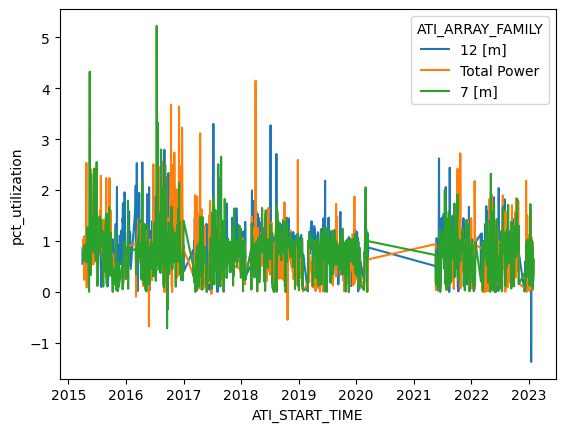

In [42]:
sns.lineplot(x='ATI_START_TIME', 
             y='pct_utilization', 
             data=ati_agg_day, 
             hue='ATI_ARRAY_FAMILY')

<AxesSubplot:xlabel='ATI_START_TIME', ylabel='pct_utilization'>

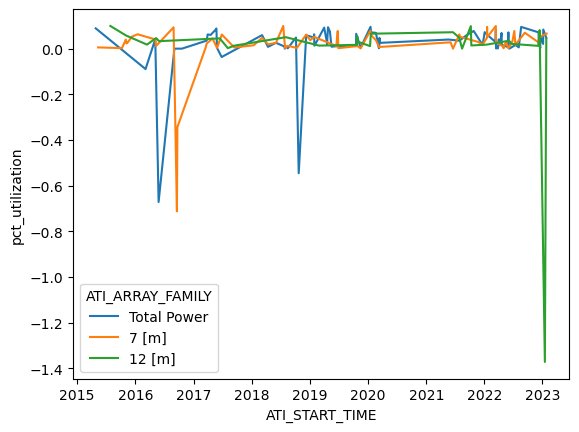

In [43]:
sns.lineplot(x='ATI_START_TIME', 
             y='pct_utilization', 
             data=ati_agg_day.query('pct_utilization <.1 '), 
             hue='ATI_ARRAY_FAMILY')

<AxesSubplot:xlabel='year', ylabel='pct_utilization'>

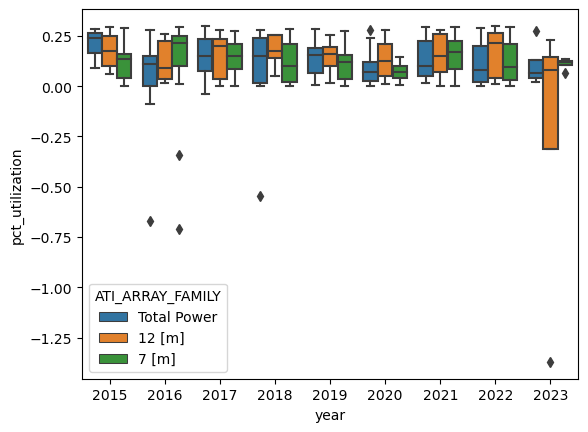

In [50]:
sns.boxplot(x='year', 
             y='pct_utilization', 
             data=ati_agg_merge.groupby(['ATI_START_TIME','year','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'median'}).reset_index().query('pct_utilization <.3 '), 
             hue='ATI_ARRAY_FAMILY')

## Review all antenna families with less than 0.1% utilization (or missing days)

In [37]:
#situation where all families were affected
ati_agg_low_util = ati_agg_day.query('pct_utilization < .3 & pct_utilization > .1 ')
ati_agg_low_util['diff']=ati_agg_low_util['ATI_START_TIME'].diff()
ati_agg_low_util['span']=ati_agg_low_util['diff'].astype('timedelta64[D]')
ati_agg_low_util=ati_agg_low_util.dropna()
ati_agg_low_util.head()

C:\Users\mattl\AppData\Local\Temp/ipykernel_5468/2951291359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ati_agg_low_util['diff']=ati_agg_low_util['ATI_START_TIME'].diff()
C:\Users\mattl\AppData\Local\Temp/ipykernel_5468/2951291359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ati_agg_low_util['span']=ati_agg_low_util['diff'].astype('timedelta64[D]')


,ATI_START_TIME,pct_utilization,diff,span
71,2015-07-06,0.242553,71 days,71.0
90,2015-08-09,0.290323,34 days,34.0
112,2015-09-06,0.107490,28 days,28.0
133,2015-10-15,0.157603,39 days,39.0
142,2015-10-25,0.238055,10 days,10.0


## All antenna survival curves

<AxesSubplot:>

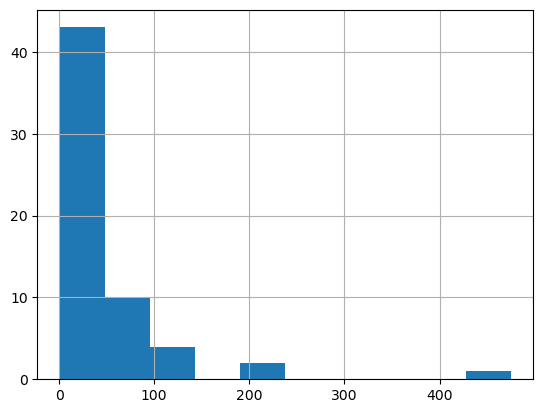

In [39]:
ati_agg_low_util['span'].hist()

In [33]:
ati_agg_low_util

,ATI_START_TIME,pct_utilization,diff,span
20,2015-04-26,0.293546,NaT,NaN
71,2015-07-06,0.242553,71 days,71.0
90,2015-08-09,0.290323,34 days,34.0
112,2015-09-06,0.107490,28 days,28.0
133,2015-10-15,0.157603,39 days,39.0
...,...,...,...,...
1869,2022-09-25,0.227139,7 days,7.0
1902,2022-10-29,0.164227,34 days,34.0
1904,2022-12-07,0.244444,39 days,39.0
1907,2022-12-13,0.254343,6 days,6.0


In [22]:
ati_agg_low_util_7m = ati_agg_merge.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'median'}).reset_index().sort_values(by=['ATI_START_TIME']).query('ATI_ARRAY_FAMILY == "7 [m]" & pct_utilization < .1 ')
ati_agg_low_util_7m['diff']=ati_agg_low_util_7m['ATI_START_TIME'].diff()
ati_agg_low_util_7m

,ATI_START_TIME,ATI_ARRAY_FAMILY,pct_utilization,diff
72,2015-05-12,7 [m],0.005376,NaT
305,2015-10-09,7 [m],0.002247,150 days
340,2015-11-02,7 [m],0.039795,24 days
346,2015-11-06,7 [m],0.022634,4 days
354,2015-11-12,7 [m],0.025180,6 days
...,...,...,...,...
4361,2022-07-15,7 [m],0.016865,7 days
4513,2022-09-12,7 [m],0.069767,59 days
4640,2022-12-09,7 [m],0.026190,88 days
4643,2022-12-10,7 [m],0.050000,1 days


In [23]:
ati_agg_low_util_12m = ati_agg_merge.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'median'}).reset_index().sort_values(by=['ATI_START_TIME']).query('ATI_ARRAY_FAMILY == "12 [m]" & pct_utilization < .1 ')
ati_agg_low_util_12m['diff']=ati_agg_low_util_12m['ATI_START_TIME'].diff()
ati_agg_low_util_12m

,ATI_START_TIME,ATI_ARRAY_FAMILY,pct_utilization,diff
206,2015-07-28,12 [m],0.099251,NaT
339,2015-11-02,12 [m],0.058041,97 days
469,2016-03-14,12 [m],0.017603,133 days
590,2016-05-10,12 [m],0.046201,57 days
635,2016-05-29,12 [m],0.032753,19 days
1375,2017-06-14,12 [m],0.044872,381 days
1454,2017-08-04,12 [m],0.002079,51 days
1535,2017-09-12,12 [m],0.012839,39 days
2203,2018-08-03,12 [m],0.050088,325 days
2709,2019-02-28,12 [m],0.013245,209 days


In [24]:
ati_agg_low_util_tp = ati_agg_merge.groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'median'}).reset_index().sort_values(by=['ATI_START_TIME']).query('ATI_ARRAY_FAMILY == "Total Power" & pct_utilization < .1 ')
ati_agg_low_util_tp['diff']=ati_agg_low_util_tp['ATI_START_TIME'].diff()
ati_agg_low_util_tp

,ATI_START_TIME,ATI_ARRAY_FAMILY,pct_utilization,diff
50,2015-04-27,Total Power,0.088889,NaT
457,2016-03-05,Total Power,-0.089397,313 days
582,2016-05-05,Total Power,0.041086,61 days
628,2016-05-26,Total Power,-0.671233,21 days
849,2016-09-02,Total Power,0.000000,99 days
...,...,...,...,...
4661,2022-12-18,Total Power,0.002472,9 days
4664,2022-12-19,Total Power,0.053528,1 days
4710,2023-01-05,Total Power,0.020713,17 days
4713,2023-01-06,Total Power,0.083650,1 days


In [ ]:



sns.boxplot(x='ATI_START_TIME', y='ATI_ARRAY_FAMILY', data=ati_agg_low_util_tp, hue='ATI_ARRAY_FAMILY')

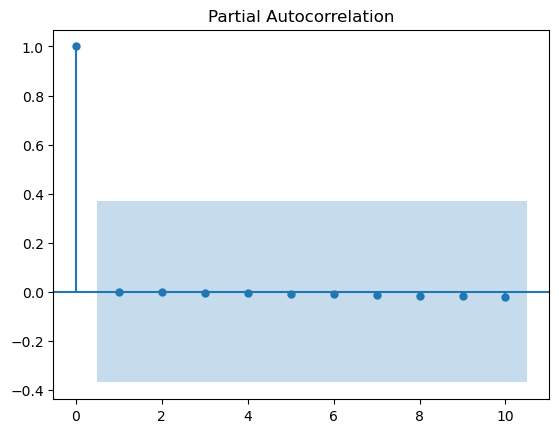

In [91]:
plot_pacf(ati_agg_low_util_12m['diff'], lags=10)
plt.show()

In [36]:
ati_agg_merge.query('pct_utilization <.1 ').head(30)

,ATI_START_TIME,hour,month,year,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,EVENTS_EB_UID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN,ATI_TIME_TOTAL,EVENTS_TIME_TOTAL,DT_TIME_TOTAL,pct_utilization
1082,2015-04-27,23,4,2015,772873,901,uid://A002/X9f54f7/X9be,Total Power,SBEX,SUCCESS,135.0,12,0,135.0,12,0,0.088889
1438,2015-05-12,20,5,2015,778126,1852,uid://A002/Xa055bc/X591,7 [m],MMEX,FAIL,930.0,2,1022,930.0,5,4088,0.005376
1439,2015-05-12,20,5,2015,778126,1852,uid://A002/Xa055bc/X5ff,7 [m],MMEX,FAIL,930.0,1,1022,930.0,5,4088,0.005376
1440,2015-05-12,20,5,2015,778126,1852,uid://A002/Xa055bc/X6d5,7 [m],MMEX,FAIL,930.0,1,1022,930.0,5,4088,0.005376
1441,2015-05-12,20,5,2015,778126,1852,uid://A002/Xa055bc/X8c3,7 [m],MMEX,FAIL,930.0,1,1022,930.0,5,4088,0.005376
3838,2015-07-28,3,7,2015,813708,4063,uid://A002/Xa6fe49/X1,12 [m],SBEX,FAIL,534.0,2,731,534.0,53,10965,0.099251
3839,2015-07-28,3,7,2015,813708,4063,uid://A002/Xa6fe49/X1488,12 [m],MMEX,FAIL,534.0,0,731,534.0,53,10965,0.099251
3840,2015-07-28,3,7,2015,813708,4063,uid://A002/Xa6fe49/X1498,12 [m],MMEX,FAIL,534.0,0,731,534.0,53,10965,0.099251
3841,2015-07-28,3,7,2015,813708,4063,uid://A002/Xa6fe49/X14a8,12 [m],MMEX,FAIL,534.0,0,731,534.0,53,10965,0.099251
3842,2015-07-28,3,7,2015,813708,4063,uid://A002/Xa6fe49/X1db,12 [m],SBEX,FAIL,534.0,6,731,534.0,53,10965,0.099251


In [10]:
# successful science observation pct successful

pct_util_sbex_success = ati_agg_merge.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS=='SUCCESS' & pct_utilization < 1 & pct_utilization > 0").groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'mean'}).reset_index()
pct_util_sbex_success['year'] = [x.year for x in pct_util_sbex_success.ATI_START_TIME]
pct_util_sbex_success

,ATI_START_TIME,ATI_ARRAY_FAMILY,pct_utilization,year
0,2015-03-31,12 [m],0.555411,2015
1,2015-04-01,12 [m],0.787529,2015
2,2015-04-01,Total Power,0.650000,2015
3,2015-04-02,12 [m],0.877214,2015
4,2015-04-03,12 [m],0.685652,2015
...,...,...,...,...
3703,2023-01-29,7 [m],0.653472,2023
3704,2023-01-29,Total Power,0.645139,2023
3705,2023-01-30,12 [m],0.230498,2023
3706,2023-01-30,7 [m],0.324880,2023


<AxesSubplot:xlabel='ATI_START_TIME', ylabel='pct_utilization'>

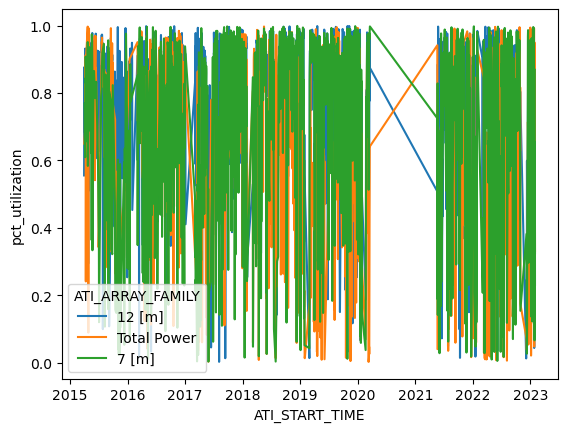

In [11]:
sns.lineplot(x='ATI_START_TIME', y='pct_utilization', data=pct_util_sbex_success, hue='ATI_ARRAY_FAMILY')

<AxesSubplot:xlabel='year', ylabel='pct_utilization'>

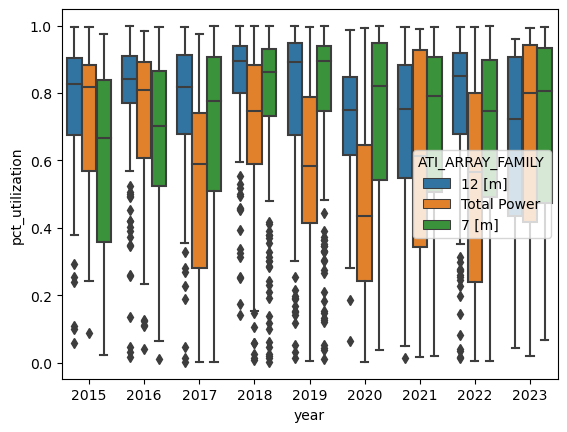

In [12]:
sns.boxplot(data=pct_util_sbex_success, x="year", y="pct_utilization", hue="ATI_ARRAY_FAMILY")

In [13]:

fig = px.box(pct_util_sbex_success, x="year", y="pct_utilization", color="ATI_ARRAY_FAMILY")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

## Successful SBEX Observations per Day

In [23]:
#sbex_obs_day = ati_agg_test.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS=='SUCCESS'").groupby(['ATI_START_TIME','ATI_SHIFT_ENTRY_ID','ATI_ARRAY_FAMILY']).agg({'EVENTS_EB_UID':'count'}).reset_index()
sbex_obs_day = ati_agg.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS=='SUCCESS' | EVENTS_EXECUTION_STATUS=='FAIL' | EVENTS_EXECUTION_STATUS=='ABORTED'").groupby(['ATI_START_TIME','ATI_SHIFT_ENTRY_ID','ATI_ARRAY_FAMILY','EVENTS_EXECUTION_STATUS']).agg({'EVENTS_EB_UID':'count'}).reset_index()
sbex_obs_day

,ATI_START_TIME,ATI_SHIFT_ENTRY_ID,ATI_ARRAY_FAMILY,EVENTS_EXECUTION_STATUS,EVENTS_EB_UID
0,2015-03-31,761400,12 [m],FAIL,9
1,2015-03-31,761400,12 [m],SUCCESS,5
2,2015-04-01,761400,12 [m],FAIL,1
3,2015-04-01,761400,12 [m],SUCCESS,2
4,2015-04-01,761400,Total Power,SUCCESS,1
...,...,...,...,...,...
11641,2023-01-30,1925292,7 [m],FAIL,2
11642,2023-01-30,1925292,7 [m],SUCCESS,24
11643,2023-01-30,1925292,Total Power,ABORTED,1
11644,2023-01-30,1925292,Total Power,FAIL,2


<AxesSubplot:xlabel='ATI_START_TIME', ylabel='EVENTS_EB_UID'>

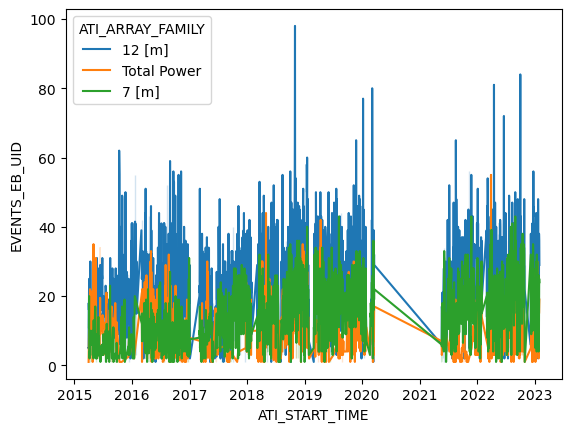

In [ ]:
sns.lineplot(x='ATI_START_TIME', y='EVENTS_EB_UID', data=sbex_obs_day, hue='ATI_ARRAY_FAMILY')

c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



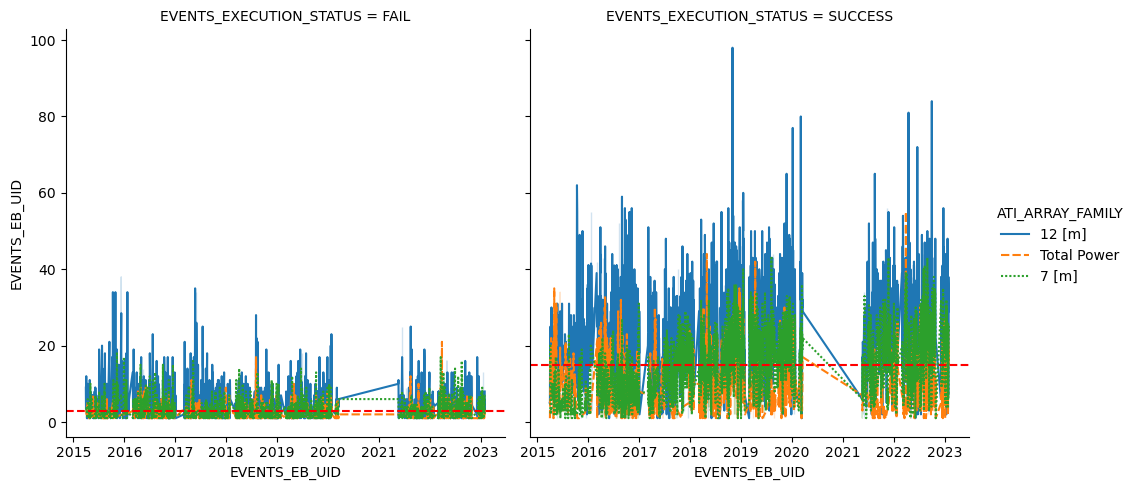

In [25]:
g=sns.relplot(
    data=sbex_obs_day.query("EVENTS_EXECUTION_STATUS=='SUCCESS' | EVENTS_EXECUTION_STATUS=='FAIL'"), x="ATI_START_TIME", y="EVENTS_EB_UID",
    col="EVENTS_EXECUTION_STATUS", hue="ATI_ARRAY_FAMILY", style="ATI_ARRAY_FAMILY",
    kind="line"
)

def specs(x, **kwargs):
    plt.axhline(x.median(), c='red', ls='--', lw=1.5)

g.map(specs,'EVENTS_EB_UID' )

In [22]:
sbex_obs_day.query('EVENTS_EXECUTION_STATUS == "ABORTED"')['EVENTS_EB_UID'].median()

1.0

## SBEX Failure Count over Time

<AxesSubplot:xlabel='ATI_START_TIME', ylabel='EVENTS_EB_UID'>

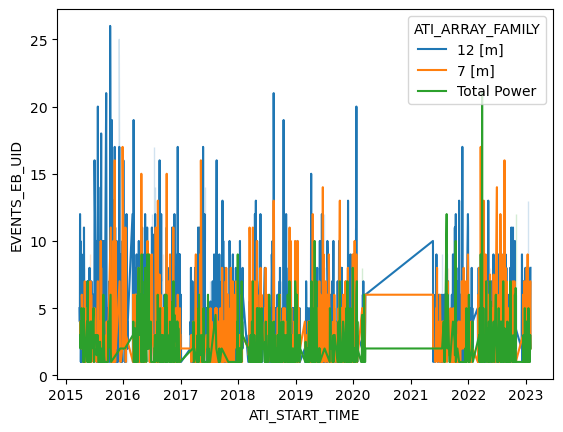

In [ ]:
sbex_obs_fail = ati_agg_test.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS == 'FAIL'").groupby([ati_agg_test.ATI_START_TIME, ati_agg_test.ATI_SHIFT_ENTRY_ID, ati_agg_test.ATI_ARRAY_FAMILY,ati_agg_test.EVENTS_EXECUTION_STATUS]).agg({'EVENTS_EB_UID':'count'}).reset_index()
sns.lineplot(x='ATI_START_TIME', y='EVENTS_EB_UID', data=sbex_obs_fail, hue='ATI_ARRAY_FAMILY')

In [29]:
sbex_obs_fail_hour = ati_agg.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS=='SUCCESS' | EVENTS_EXECUTION_STATUS=='FAIL'").groupby([ati_agg.ATI_START_TIME, ati_agg.hour, ati_agg.ATI_ARRAY_FAMILY,ati_agg.EVENTS_EXECUTION_STATUS]).agg({'EVENTS_EB_UID':'count'}).reset_index()
sbex_obs_fail_hour = sbex_obs_fail_hour.groupby(['ATI_ARRAY_FAMILY','EVENTS_EXECUTION_STATUS','hour']).agg('sum').reset_index()
sbex_obs_fail_hour


C:\Users\mattl\AppData\Local\Temp/ipykernel_29832/502089921.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,ATI_ARRAY_FAMILY,EVENTS_EXECUTION_STATUS,hour,EVENTS_EB_UID
0,12 [m],FAIL,0,188
1,12 [m],FAIL,1,87
2,12 [m],FAIL,2,126
3,12 [m],FAIL,3,80
4,12 [m],FAIL,4,98
...,...,...,...,...
139,Total Power,SUCCESS,19,1062
140,Total Power,SUCCESS,20,1393
141,Total Power,SUCCESS,21,1283
142,Total Power,SUCCESS,22,1039


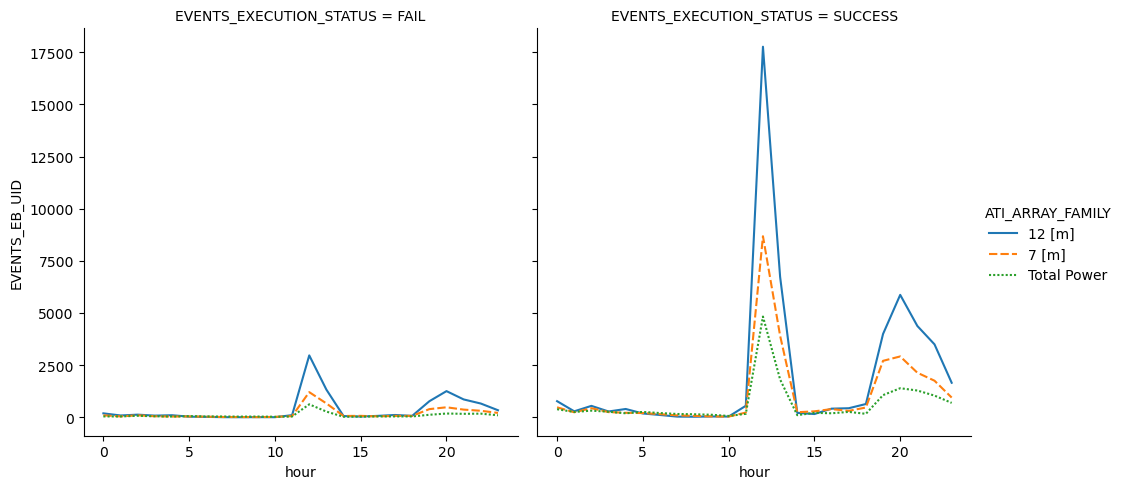

In [30]:
#sns.lineplot(x='hour', y='EVENTS_EB_UID', data=sbex_obs_fail_hour, hue='ATI_ARRAY_FAMILY')

sns.relplot(
    data=sbex_obs_fail_hour, x="hour", y="EVENTS_EB_UID",
    col="EVENTS_EXECUTION_STATUS", hue="ATI_ARRAY_FAMILY", style="ATI_ARRAY_FAMILY",
    kind="line"
)



In [28]:
sbex_obs_fail_month = ati_agg.query("EVENT_CODE == 'SBEX' & EVENTS_EXECUTION_STATUS=='SUCCESS' | EVENTS_EXECUTION_STATUS=='FAIL'").groupby([ati_agg.ATI_START_TIME, ati_agg.month, ati_agg.ATI_ARRAY_FAMILY,ati_agg.EVENTS_EXECUTION_STATUS]).agg({'EVENTS_EB_UID':'count'}).reset_index()
sbex_obs_fail_month = sbex_obs_fail_month.groupby(['ATI_ARRAY_FAMILY','EVENTS_EXECUTION_STATUS','month']).agg('sum').reset_index()
sbex_obs_fail_month.head()


C:\Users\mattl\AppData\Local\Temp/ipykernel_29832/1532748219.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,ATI_ARRAY_FAMILY,EVENTS_EXECUTION_STATUS,month,EVENTS_EB_UID
0,12 [m],FAIL,1,806
1,12 [m],FAIL,2,7
2,12 [m],FAIL,3,669
3,12 [m],FAIL,4,825
4,12 [m],FAIL,5,847


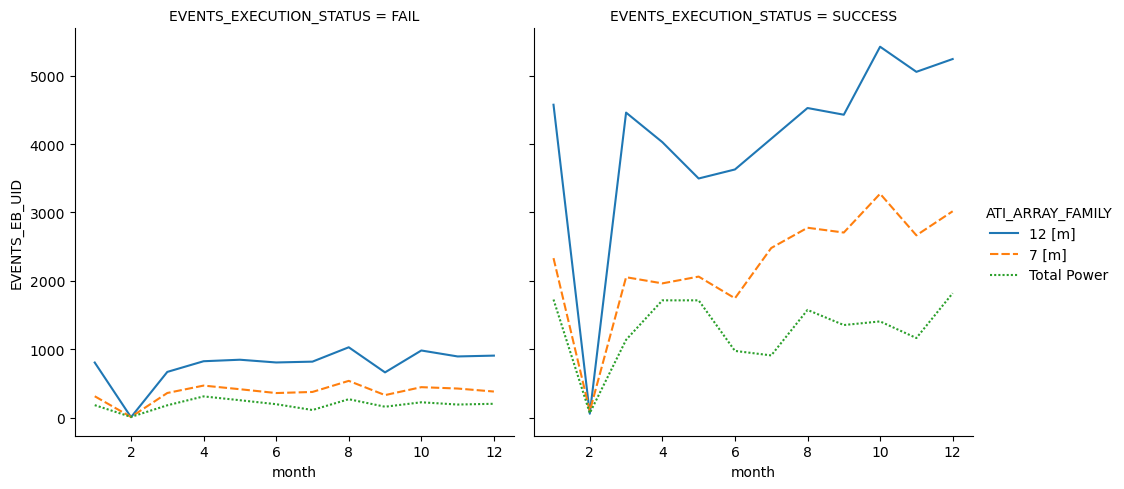

In [31]:
#sns.lineplot(x='month', y='EVENTS_EB_UID', data=sbex_obs_fail_month, hue='ATI_ARRAY_FAMILY')

sns.relplot(
    data=sbex_obs_fail_month, x="month", y="EVENTS_EB_UID",
    col="EVENTS_EXECUTION_STATUS", hue="ATI_ARRAY_FAMILY", style="ATI_ARRAY_FAMILY",
    kind="line"
)


In [ ]:
ati_agg_test.query('ATI_SHIFT_ENTRY_ID == 1537046').head(30)


,ATI_START_TIME,hour,month,year,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,EVENTS_EB_UID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN
69786,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/X1054e,12 [m],SBEX,SUCCESS,1019.0,77,0
69787,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/X10de2,12 [m],SBEX,ABORTED,1019.0,2,0
69788,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/X10e48,12 [m],SBEX,SUCCESS,1019.0,8,0
69789,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/X1102a,12 [m],SBEX,SUCCESS,1019.0,24,0
69790,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xba53,12 [m],SBEX,SUCCESS,1019.0,6,0
69791,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xba7d,12 [m],SBEX,SUCCESS,1019.0,2,0
69792,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xbaf8,12 [m],SBEX,SUCCESS,1019.0,2,0
69793,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xbc30,12 [m],SBEX,SUCCESS,1019.0,5,0
69794,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xbc92,12 [m],SBEX,SUCCESS,1019.0,2,0
69795,2019-03-18 19:00:01+00:00,19,3,2019,1537046,39801,uid://A002/Xd99ff3/Xbcac,12 [m],SBEX,SUCCESS,1019.0,8,0


In [ ]:
ati_agg_test['EVENT_SPAN_SUM'] = ati_agg_test.groupby(['ATI_SHIFT_ENTRY_ID','ATI_ARRAY_FAMILY'])['EVENTS_TIME_SPAN'].transform(np.sum)
ati_agg_test['pct_utilization'] = ati_agg_test['EVENT_SPAN_SUM'] / ati_agg_test['ATI_TIME_SPAN']
ati_agg_test.head(20)

,ATI_START_TIME,hour,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,ATI_TIME_SPAN,EVENTS_TIME_SPAN,DT_TIME_SPAN,EVENT_SPAN_SUM,pct_utilization
0,2015-03-31 20:06:56.464000+00:00,20,761400,61,12 [m],MMEX,FAIL,767.0,1,16,512,0.667536
1,2015-03-31 20:06:56.464000+00:00,20,761400,61,12 [m],MMEX,SUCCESS,767.0,204,0,512,0.667536
2,2015-03-31 20:06:56.464000+00:00,20,761400,61,12 [m],SBEX,FAIL,767.0,13,0,512,0.667536
3,2015-03-31 20:06:56.464000+00:00,20,761400,61,12 [m],SBEX,SUCCESS,767.0,208,0,512,0.667536
4,2015-04-01 08:54:05.723000+00:00,8,761400,81,Total Power,MMEX,SUCCESS,60.0,4,0,39,0.650000
5,2015-04-01 08:54:05.723000+00:00,8,761400,81,Total Power,SBEX,SUCCESS,60.0,35,0,39,0.650000
6,2015-04-01 09:54:14.959000+00:00,9,761400,101,12 [m],MMEX,FAIL,63.0,1,0,512,8.126984
7,2015-04-01 09:54:14.959000+00:00,9,761400,101,12 [m],MMEX,SUCCESS,63.0,10,0,512,8.126984
8,2015-04-01 09:54:14.959000+00:00,9,761400,101,12 [m],SBEX,SUCCESS,63.0,26,0,512,8.126984
9,2015-04-01 11:11:06.848000+00:00,11,761400,82,12 [m],SBEX,SUCCESS,50.0,49,0,512,10.240000


Text(0.5, 1.0, 'Count of Successes and Failures for Science Observations (SBEX) by Array Family')

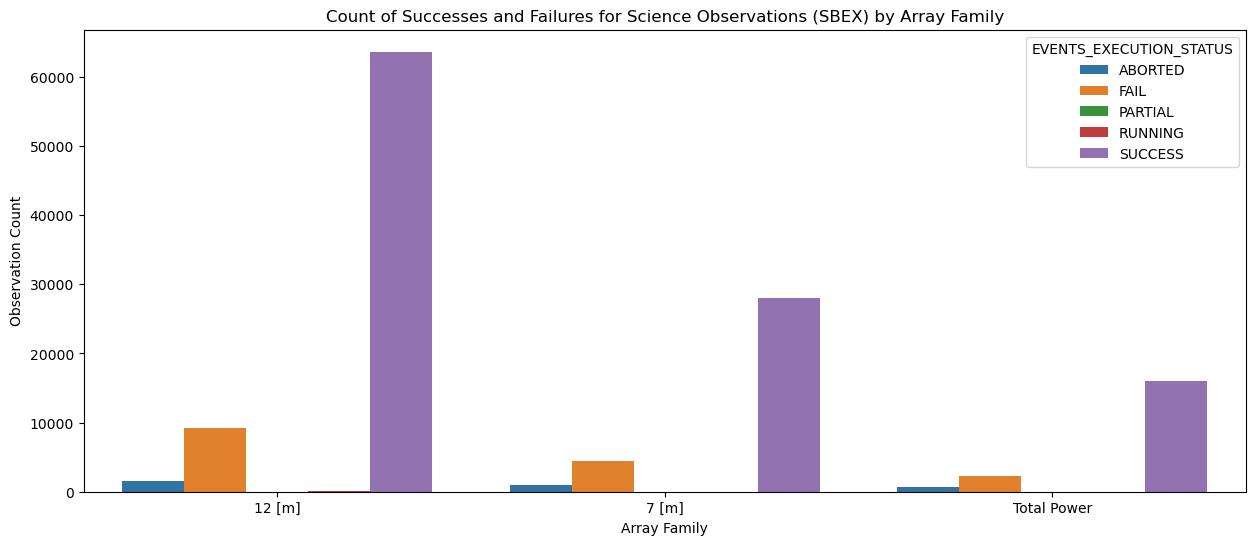

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x='ATI_ARRAY_FAMILY', 
            y='EVENTS_EB_UID',
            hue='EVENTS_EXECUTION_STATUS', 
            data=ati_sbex_fail_count)
plt.ylabel('Observation Count')
plt.xlabel('Array Family')
plt.title('Count of Successes and Failures for Science Observations (SBEX) by Array Family')

In [ ]:
# create data frame and aggregate by day
ati_agg_test_sbex = (ati_agg_test.query('EVENT_CODE == "SBEX" & pct_utilization < 1.5 & pct_utilization > 0')).groupby(['ATI_START_TIME','ATI_ARRAY_FAMILY']).agg({'pct_utilization':'median'}).reset_index()
ati_agg_test_sbex

,ATI_START_TIME,ATI_ARRAY_FAMILY,pct_utilization
0,2015-03-31 20:06:56.464000+00:00,12 [m],0.667536
1,2015-04-01 08:54:05.723000+00:00,Total Power,0.650000
2,2015-04-01 21:31:33.061000+00:00,12 [m],0.688222
3,2015-04-02 21:52:55.018000+00:00,12 [m],0.877214
4,2015-04-03 20:50:37.226000+00:00,12 [m],0.685652
...,...,...,...
5064,2023-01-29 12:00:02+00:00,7 [m],0.653472
5065,2023-01-29 12:00:02+00:00,Total Power,0.645139
5066,2023-01-30 12:00:41.932000+00:00,12 [m],0.230498
5067,2023-01-30 12:00:44.846000+00:00,7 [m],0.324880


## % Utilization of array family over all time

Text(0.5, 1.0, '% Utilization of Array Family across observed data')

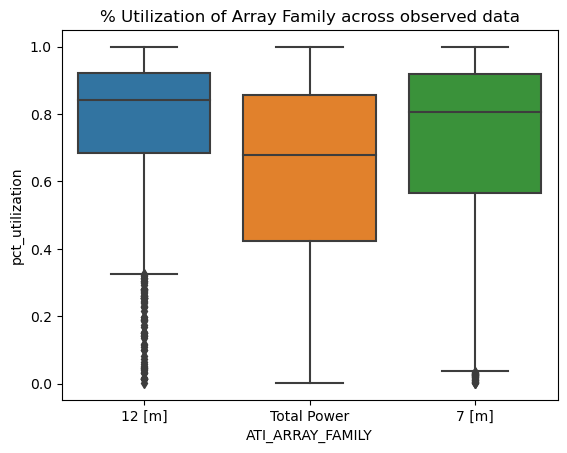

In [18]:
#sns.boxplot(x = 'ATI_ARRAY_FAMILY', y = 'pct_utilization', data = ati_agg_test_sbex)
sns.boxplot(data=pct_util_sbex_success, x="ATI_ARRAY_FAMILY", y="pct_utilization")
plt.title("% Utilization of Array Family across observed data")

## % utilization over time

<AxesSubplot:xlabel='ATI_START_TIME', ylabel='pct_utilization'>

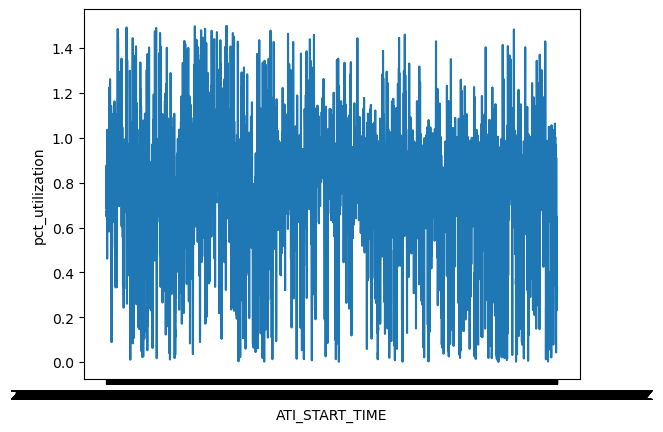

In [ ]:
sns.lineplot(x='ATI_START_TIME', 
             y='pct_utilization', 
             data=ati_agg_test_sbex.query('pct_utilization < 1.5 & pct_utilization > 0'))

In [ ]:
ati_agg_melt = pd.melt(ati_agg_test, 
                       id_vars=['ATI_START_TIME','ATI_SHIFT_ENTRY_ID','ATI_ALLOCATED_TIME_INTERVAL_ID','ATI_ARRAY_FAMILY','EVENT_CODE','EVENTS_EXECUTION_STATUS'], 
                       value_vars=['ATI_TIME_SPAN','EVENTS_TIME_SPAN','DT_TIME_SPAN'])
ati_agg_melt

,ATI_START_TIME,ATI_SHIFT_ENTRY_ID,ATI_ALLOCATED_TIME_INTERVAL_ID,ATI_ARRAY_FAMILY,EVENT_CODE,EVENTS_EXECUTION_STATUS,variable,value
0,2015-03-31T20:06:56.464Z,761400,61,12 [m],MMEX,FAIL,ATI_TIME_SPAN,767.0
1,2015-03-31T20:06:56.464Z,761400,61,12 [m],MMEX,SUCCESS,ATI_TIME_SPAN,767.0
2,2015-03-31T20:06:56.464Z,761400,61,12 [m],SBEX,FAIL,ATI_TIME_SPAN,767.0
3,2015-03-31T20:06:56.464Z,761400,61,12 [m],SBEX,SUCCESS,ATI_TIME_SPAN,767.0
4,2015-04-01T08:54:05.723Z,761400,81,Total Power,MMEX,SUCCESS,ATI_TIME_SPAN,60.0
...,...,...,...,...,...,...,...,...
42826,2023-01-30T12:00:44.846Z,1925292,53832,7 [m],SBEX,FAIL,DT_TIME_SPAN,0.0
42827,2023-01-30T12:00:44.846Z,1925292,53832,7 [m],SBEX,SUCCESS,DT_TIME_SPAN,0.0
42828,2023-01-30T12:00:47.247Z,1925292,53833,Total Power,SBEX,ABORTED,DT_TIME_SPAN,0.0
42829,2023-01-30T12:00:47.247Z,1925292,53833,Total Power,SBEX,FAIL,DT_TIME_SPAN,0.0


c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\mattl\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

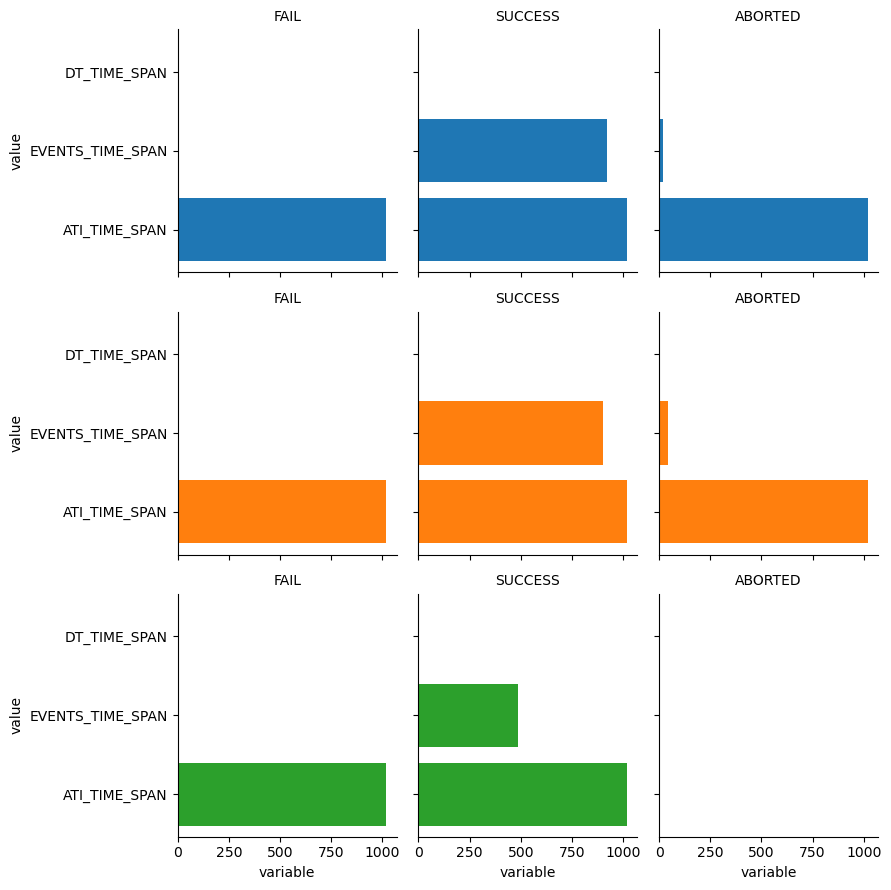

In [ ]:


g = sns.FacetGrid(ati_agg_melt.query('ATI_SHIFT_ENTRY_ID == 1537046'), 
                  row = 'ATI_ARRAY_FAMILY', 
                  col = 'EVENTS_EXECUTION_STATUS',
                  hue='ATI_ARRAY_FAMILY')
g.map(plt.barh, 'variable', 'value')
g.set_titles('{col_name}')